# Kundur Two Areas

## Run simulation

### Import Libraries

In [1]:
import sys
sys.path.insert(0,'/home/mmo/git/pscc/dpsim/python/src/dpsim')
sys.path.insert(0,'/home/mmo/git/pscc/dpsim/build')
sys.path.remove('/home/mmo/git/lund-anm-control')

import matpower
import dpsimpy

from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import urllib.request
import matplotlib.pyplot as plt

%matplotlib widget

print(dpsimpy.__file__)

/home/mmo/git/pscc/dpsim/build/dpsimpy.cpython-39-x86_64-linux-gnu.so


### Simulation parameters

In [2]:
# simulation files
path_static_file =  '/home/mmo/git/pscc/dpsim/examples/Notebooks/MatDyn/Kundur2Areas/Kundur2Areas.mat'
path_dynamic_file = '/home/mmo/git/pscc/dpsim/examples/Notebooks/MatDyn/Kundur2Areas/Kundur2Areas_dyn.mat'

### 1. Powerflow for initialization

In [3]:
sim_name_pf = 'Kundur2Areas_PF'
dpsimpy.Logger.set_log_dir('logs/' + sim_name_pf)

# read and create dpsim topology
mpc_reader = matpower.Reader(mpc_file_path=path_static_file, mpc_name='Kundur2Areas',
                             mpc_dyn_file_path=path_dynamic_file, mpc_dyn_name='Kundur2Areas_dyn')
mpc_reader.load_mpc(domain=matpower.Domain.PF)
system_pf = mpc_reader.system

# log results
logger = dpsimpy.Logger(sim_name_pf)
for node in system_pf.nodes:
    logger.log_attribute(node.name()+'.V', 'v', node)
    logger.log_attribute(node.name()+'.S', 's', node)

# Parametrize and run simulation
sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.info)
sim_pf.set_system(system_pf)
sim_pf.set_time_step(1)
sim_pf.set_final_time(0.1)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.do_init_from_nodes_and_terminals(False)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.add_logger(logger)
sim_pf.run()

[09:26:47.924925 Kundur2Areas_PF info] Initialize simulation: Kundur2Areas_PF
[09:26:47.925286 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N5
[09:26:47.925293 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N6
[09:26:47.925296 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N7
[09:26:47.925298 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N7
[09:26:47.925301 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N8
[09:26:47.925304 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N9
[09:26:47.925305 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N9
[09:26:47.925308 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N10
[09:26:47.925311 Kundur2Areas_PF_PF_Solver warning] Unable to get base voltage at N11
[09:26:47.925512 Kundur2Areas_PF info] Scheduling tasks.
[09:26:47.925693 Kundur2Areas_PF info] Scheduling done.
[09:26:47.925695 Kundur2Areas_PF info] Ope

### 2. Dynamic simulation with Inverter (steady state)

#### Inverter parameters

In [4]:
# Inverter parameters
omega = 2*np.pi*60
Vdref = 20e3*1.01
Vqref = 0
Pref=700e6

# Controller parameters
KpVoltageCtrl = 0.210420000000000
KiVoltageCtrl = 98.414400000000000
KpCurrCtrl = 5.158400000000000
KiCurrCtrl = 90.424600000000000

# VSO/PLL controller parameters
# OmegaCutoff is the cutoff-frequency of the PLL filter
# in case of VCO-mode use KpPLL=0, KiPLL=0 and OmegaCutoff = OmegaNull to work as VCO
KpPLL=0
KiPLL=0 
OmegaCutoff = 2*np.pi*60

# VSI filter parameters
Lf = 0.0051
Rf = 0.1
Cf = 2.9842e-4
Rc = 1e-12

# Droop control parameters
m_p=2.094395102393195e-08
tau_p=1
tau_l=0.001

#### Dynamic Simulation

In [5]:
def Kundur2Areas_Fault(domain="DP", with_inverter1=True, with_inverter2=True, with_fault=False, with_droop_control = False):
    
    sim_name_dyn = domain + "_Kundur2Areas_Fault"
    if with_inverter1:
        sim_name_dyn = sim_name_dyn + "_1Inverter"
    if with_inverter2:
        sim_name_dyn = sim_name_dyn + "_2Inverters"
    sim_name_dyn = sim_name_dyn + "_ohneDroop"
    dpsimpy.Logger.set_log_dir('logs/' + sim_name_dyn)

    mpc_reader2 = matpower.Reader(mpc_file_path=path_static_file, mpc_name='Kundur2Areas',
                                  mpc_dyn_file_path=path_dynamic_file, mpc_dyn_name='Kundur2Areas_dyn')

    if domain=="SP":    
        mpc_reader2.create_dpsim_objects(domain=matpower.Domain.SP, frequency=60, 
                                with_avr=False, with_tg=False, with_pss=False)
    if domain=="DP":    
        mpc_reader2.create_dpsim_objects(domain=matpower.Domain.DP, frequency=60, 
                                 with_avr=False, with_tg=False, with_pss=False)
    if domain=="EMT":
        mpc_reader2.create_dpsim_objects(domain=matpower.Domain.EMT, frequency=60, 
                                 with_avr=False, with_tg=False, with_pss=False)        
            
    # list of generators
    inverter_list = []
    gen_list = ['Gen_N1', 'Gen_N2', 'Gen_N3', 'Gen_N4']
    
    ### Replace Gen2 by Inverter
    inverter1=None
    if with_inverter1:
        if domain=="SP":    
            inverter1=dpsimpy.sp.ph1.VSIVoltageControlDQ('Gen_N2', 'Gen_N2', dpsimpy.LogLevel.info, with_droop_control=with_droop_control)
        if domain=="DP":    
            inverter1=dpsimpy.dp.ph1.VSIVoltageControlDQ('Gen_N2', 'Gen_N2', dpsimpy.LogLevel.info, with_droop_control=with_droop_control)
        if domain=="EMT":    
            inverter1=dpsimpy.emt.ph3.VSIVoltageControlDQ('Gen_N2', 'Gen_N2', dpsimpy.LogLevel.info, with_droop_control=with_droop_control)
        
        inverter1.set_parameters(sys_omega=omega, vd_ref=Vdref, vq_ref=Vqref, p_ref=Pref)
        inverter1.set_droop_parameters(m_p=m_p, tau_p=tau_p, tau_l=tau_l)
        inverter1.set_controller_parameters(Kp_voltage_ctrl=KpVoltageCtrl, Ki_voltage_ctrl=KiVoltageCtrl,
                                           Kp_curr_ctrl=KpCurrCtrl, Ki_curr_ctrl=KiCurrCtrl, omega_cutoff=OmegaCutoff)
        inverter1.set_filter_parameters(Lf=Lf, Cf=Cf, Rf=Rf, Rc=Rc)
        inverter1.with_control(True)
        mpc_reader2.dpsimpy_comp_dict["Gen_N2"][0] = inverter1
        inverter_list.append(inverter1)
        gen_list.remove('Gen_N2')
    
    ### Replace Gen2 by Inverter
    inverter2=None  
    if with_inverter2:
        ### Replace Gen4 by Inverter
        if domain=="SP":    
            inverter2=dpsimpy.sp.ph1.VSIVoltageControlDQ('Gen_N4', 'Gen_N4', dpsimpy.LogLevel.info, with_droop_control=with_droop_control)
        elif domain=="DP":    
            inverter2=dpsimpy.dp.ph1.VSIVoltageControlDQ('Gen_N4', 'Gen_N4', dpsimpy.LogLevel.info, with_droop_control=with_droop_control)
        else:
            inverter2=dpsimpy.emt.ph3.VSIVoltageControlDQ('Gen_N4', 'Gen_N4', dpsimpy.LogLevel.info, with_droop_control=with_droop_control) 
        
        inverter2.set_parameters(sys_omega=omega, vd_ref=Vdref, vq_ref=Vqref, p_ref=Pref)
        inverter2.set_droop_parameters(m_p=m_p, tau_p=tau_p, tau_l=tau_l)
        inverter2.with_droop_control(True)    
        inverter2.set_controller_parameters(Kp_voltage_ctrl=KpVoltageCtrl, Ki_voltage_ctrl=KiVoltageCtrl,
                                            Kp_curr_ctrl=KpCurrCtrl, Ki_curr_ctrl=KiCurrCtrl, omega_cutoff=OmegaCutoff)
        inverter2.set_filter_parameters(Lf=Lf, Cf=Cf, Rf=Rf, Rc=Rc)
        inverter2.with_control(True)
        mpc_reader2.dpsimpy_comp_dict["Gen_N4"][0] = inverter2
        inverter_list.append(inverter2)
        gen_list.remove('Gen_N4')
        
    sw = None
    if with_fault:
        ### Extend topology with switch between node N7 and groud    
        if domain=="SP":    
            sw = dpsimpy.sp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
            sw.set_parameters(1e18, 0.001)
            sw.open()
            mpc_reader2.dpsimpy_comp_dict['Fault'] = [sw]
            mpc_reader2.dpsimpy_comp_dict['Fault'].append([dpsimpy.sp.SimNode.gnd, mpc_reader2.dpsimpy_busses_dict["N7"]])
        elif domain=="DP":    
            sw = dpsimpy.dp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
            sw.set_parameters(1e18, 0.001)
            sw.open()
            mpc_reader2.dpsimpy_comp_dict['Fault'] = [sw]
            mpc_reader2.dpsimpy_comp_dict['Fault'].append([dpsimpy.dp.SimNode.gnd, mpc_reader2.dpsimpy_busses_dict["N7"]])
        else:    
            sw = dpsimpy.emt.ph3.SeriesSwitch('Fault', dpsimpy.LogLevel.info)
            sw.set_parameters(1e18, 0.001)
            sw.open()
            mpc_reader2.dpsimpy_comp_dict['Fault'] = [sw]
            mpc_reader2.dpsimpy_comp_dict['Fault'].append([dpsimpy.emt.SimNode.gnd, mpc_reader2.dpsimpy_busses_dict["N7"]])


    # create dpsim topology
    mpc_reader2.create_dpsim_topology()

    #initialize node voltages using pf results
    system_dyn = mpc_reader2.system
    if domain=="SP":    
        system_dyn.init_with_powerflow(systemPF=system_pf, domain=dpsimpy.Domain.SP)
    elif domain=="DP":    
        system_dyn.init_with_powerflow(systemPF=system_pf, domain=dpsimpy.Domain.DP)
    else:
        system_dyn.init_with_powerflow(systemPF=system_pf, domain=dpsimpy.Domain.EMT)

    # log results
    logger = dpsimpy.Logger(sim_name_dyn)

    # System voltages and currents
    #for node in system_dyn.nodes:
    for node_name in ["N7", "N8"]:
        logger.log_attribute(node_name+'.V', 'v', mpc_reader2.dpsimpy_busses_dict[node_name])
        
    logger.log_attribute('line3_7-8.I', 'i_intf', mpc_reader2.dpsimpy_comp_dict['line3_7-8'][0])
    logger.log_attribute('line4_7-8.I', 'i_intf', mpc_reader2.dpsimpy_comp_dict['line4_7-8'][0])
    logger.log_attribute('line5_8-9.I', 'i_intf', mpc_reader2.dpsimpy_comp_dict['line5_8-9'][0])
    logger.log_attribute('line6_8-9.I', 'i_intf', mpc_reader2.dpsimpy_comp_dict['line6_8-9'][0])
    
    if with_fault:
        logger.log_attribute("Switch.I", 'i_intf', sw)
    
    # Log electrical power and omega of SGs
    for gen_name in gen_list:
        logger.log_attribute('{}.Pe'.format(gen_name), 'Te', mpc_reader2.dpsimpy_comp_dict[gen_name][0])
        logger.log_attribute('{}.w'.format(gen_name), 'w_r', mpc_reader2.dpsimpy_comp_dict[gen_name][0])
        
    # Log electrical power and droop output of Inverters
    for idx, inverter in enumerate(inverter_list):
        logger.log_attribute('Inverter{}.I'.format(idx+1), 'i_intf', inverter)
        logger.log_attribute('Inverter{}.Pe'.format(idx+1), 'P_elec', inverter)
        #logger.log_attribute('Inverter{}.Vcd'.format(idx+1), 'Vc_d', inverter)
        #logger.log_attribute('Inverter{}.Vcq'.format(idx+1), 'Vc_q', inverter)
        logger.log_attribute('Inverter{}.Vsref'.format(idx+1), 'Vsref', inverter)
        #logger.log_attribute('Inverter{}.ThetaNom'.format(idx), 'ThetaNom', inverter)
        #logger.log_attribute('Inverter{}.Irc_d'.format(idx), 'Irc_d', inverter)
        #logger.log_attribute('Inverter{}.Irc_q'.format(idx), 'Irc_q', inverter)
        logger.log_attribute('Inverter{}.w'.format(idx+1), 'Omega', inverter)
        logger.log_attribute('Inverter{}.Theta'.format(idx+1), 'Theta', inverter)
        logger.log_attribute('Inverter{}.ThetaSys'.format(idx+1), 'ThetaSys', inverter)
    
    # Parametrize and run simulation
    sim = dpsimpy.Simulation(sim_name_dyn, dpsimpy.LogLevel.info)
    sim.set_system(system_dyn)
    sim.set_time_step(1e-4)
    sim.set_final_time(30)
    if domain=="SP":
        sim.set_domain(dpsimpy.Domain.SP)
    if domain=="DP":
        sim.set_domain(dpsimpy.Domain.DP)
    if domain=="EMT":
        sim.set_domain(dpsimpy.Domain.EMT)    
    sim.set_solver(dpsimpy.Solver.MNA)
    sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
    sim.do_init_from_nodes_and_terminals(True)
    sim.add_logger(logger)
    sim.do_system_matrix_recomputation(True)

    if with_fault:
        # add event
        sw_event_1 = dpsimpy.event.SwitchEvent(1, sw, True)
        sim.add_event(sw_event_1)

        sw_event_2 = dpsimpy.event.SwitchEvent(1.1, sw, False)
        sim.add_event(sw_event_2)

    sim.run()
    return sim_name_dyn, inverter_list, gen_list

#### Run simulation

In [6]:
with_inverter1=True
with_inverter2=False
with_fault=True
with_droop_control=False

In [7]:
sim_name_emt_1inverter, inverter_list_1inverter, gen_list_1inverter = Kundur2Areas_Fault("EMT", with_inverter1=with_inverter1, with_inverter2=with_inverter2, with_fault=with_fault, with_droop_control=with_droop_control)

1.000000e+00: Handle event time


[09:26:48.013409 EMT_Kundur2Areas_Fault_1Inverter_ohneDroop info] Initialize simulation: EMT_Kundur2Areas_Fault_1Inverter_ohneDroop
[09:26:48.023813 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[09:26:48.037927 EMT_Kundur2Areas_Fault_1Inverter_ohneDroop_Solver warning] Linear solver configuration is not used!
[09:26:48.061074 EMT_Kundur2Areas_Fault_1Inverter_ohneDroop info] Scheduling tasks.
[09:26:48.061556 EMT_Kundur2Areas_Fault_1Inverter_ohneDroop info] Scheduling done.
[09:26:48.061571 EMT_Kundur2Areas_Fault_1Inverter_ohneDroop info] Opening interfaces.
[09:26:48.061573 EMT_Kundur2Areas_Fault_1Inverter_ohneDroop info] Start synchronization with remotes on interfaces
[09:26:48.061575 EMT_Kundur2Areas_Fault_1Inverter_ohneDroop info] Synchronized simulation start with remotes
[09:26:48.061577 EMT_Kundur2Areas_Fault_1Inverter_ohneDroop info] Start simulation: EMT_Kundur2Areas_Fault_1Inverter_ohneDroop
[09:26:48.061580 EMT_Kundur2Areas_Fault_1Inverter_ohneDroop 

1.100000e+00: Handle event time


In [8]:
sim_name_dp_1inverter, inverter_list_1inverter, gen_list_1inverter = Kundur2Areas_Fault("DP", with_inverter1=with_inverter1, with_inverter2=with_inverter2, with_fault=with_fault, with_droop_control=with_droop_control)

1.000000e+00: Handle event time


[09:27:07.518818 DP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Initialize simulation: DP_Kundur2Areas_Fault_1Inverter_ohneDroop


1.100000e+00: Handle event time


[09:27:07.518886 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[09:27:07.522136 DP_Kundur2Areas_Fault_1Inverter_ohneDroop_Solver warning] Linear solver configuration is not used!
[09:27:07.525945 DP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Scheduling tasks.
[09:27:07.526313 DP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Scheduling done.
[09:27:07.526316 DP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Opening interfaces.
[09:27:07.526317 DP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Start synchronization with remotes on interfaces
[09:27:07.526318 DP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Synchronized simulation start with remotes
[09:27:07.526320 DP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Start simulation: DP_Kundur2Areas_Fault_1Inverter_ohneDroop
[09:27:07.526322 DP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Time step: 1.000000e-04
[09:27:07.526324 DP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Final time: 3.000000e+01
[09:27:20.002499 DP_K

In [9]:
sim_name_sp_1inverter, inverter_list_1inverter, gen_list_1inverter = Kundur2Areas_Fault("SP", with_inverter1=with_inverter1, with_inverter2=with_inverter2, with_fault=with_fault, with_droop_control=with_droop_control)

1.000000e+00: Handle event time


[09:27:20.050839 SP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Initialize simulation: SP_Kundur2Areas_Fault_1Inverter_ohneDroop
[09:27:20.050911 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[09:27:20.053251 SP_Kundur2Areas_Fault_1Inverter_ohneDroop_Solver warning] Linear solver configuration is not used!
[09:27:20.056671 SP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Scheduling tasks.
[09:27:20.056911 SP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Scheduling done.
[09:27:20.056913 SP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Opening interfaces.
[09:27:20.056914 SP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Start synchronization with remotes on interfaces
[09:27:20.056915 SP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Synchronized simulation start with remotes
[09:27:20.056916 SP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Start simulation: SP_Kundur2Areas_Fault_1Inverter_ohneDroop
[09:27:20.056918 SP_Kundur2Areas_Fault_1Inverter_ohneDroop info] Time 

1.100000e+00: Handle event time


#### Read results

In [10]:
from villas.dataprocessing.timeseries import TimeSeries as ts
import villas.dataprocessing.plottools as pt

# sim_name_emt_1inverter = 'EMT_Kundur2Areas_Fault_1Inverter'
# sim_name_dp_1inverter = 'DP_Kundur2Areas_Fault_1Inverter'
# sim_name_sp_1inverter = 'SP_Kundur2Areas_Fault_1Inverter'

dpsim_result_file = 'logs/' + sim_name_emt_1inverter + '/' + sim_name_emt_1inverter + '.csv'
ts_dpsim_emt_1inverter = read_timeseries_csv(dpsim_result_file)

dpsim_result_file = 'logs/' + sim_name_dp_1inverter + '/' + sim_name_dp_1inverter + '.csv'
ts_dpsim_dp_1inverter = read_timeseries_csv(dpsim_result_file)

dpsim_result_file = 'logs/' + sim_name_sp_1inverter + '/' + sim_name_sp_1inverter + '.csv'
ts_dpsim_sp_1inverter = read_timeseries_csv(dpsim_result_file)

column number: 37
results length: 300001
real column names: ['Gen_N1.Pe', 'Gen_N1.w', 'Gen_N3.Pe', 'Gen_N3.w', 'Gen_N4.Pe', 'Gen_N4.w', 'Inverter1.I_0', 'Inverter1.I_1', 'Inverter1.I_2', 'Inverter1.Pe', 'Inverter1.Theta', 'Inverter1.ThetaSys', 'Inverter1.Vsref_0', 'Inverter1.Vsref_1', 'Inverter1.Vsref_2', 'Inverter1.w', 'N7.V_0', 'N7.V_1', 'N7.V_2', 'N8.V_0', 'N8.V_1', 'N8.V_2', 'Switch.I_0', 'Switch.I_1', 'Switch.I_2', 'line3_7-8.I_0', 'line3_7-8.I_1', 'line3_7-8.I_2', 'line4_7-8.I_0', 'line4_7-8.I_1', 'line4_7-8.I_2', 'line5_8-9.I_0', 'line5_8-9.I_1', 'line5_8-9.I_2', 'line6_8-9.I_0', 'line6_8-9.I_1', 'line6_8-9.I_2']
complex column names: []
column number: 19
results length: 300001
real column names: ['Gen_N1.Pe', 'Gen_N1.w', 'Gen_N3.Pe', 'Gen_N3.w', 'Gen_N4.Pe', 'Gen_N4.w', 'Inverter1.Pe', 'Inverter1.Theta', 'Inverter1.ThetaSys', 'Inverter1.w']
complex column names: ['Inverter1.I', 'Inverter1.Vsref', 'N7.V', 'N8.V', 'Switch.I', 'line3_7-8.I', 'line4_7-8.I', 'line5_8-9.I', 'line6_8-

In [11]:
def plot_varible(ts_dpsim_emt, ts_dpsim_dp, ts_dpsim_sp, gen_list, inverter_list, variable_name, y_lim=[], x_lim=[], divider=1):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Plot electrical power SG
    for gen_name in gen_list:
        axes[0].plot(ts_dpsim_emt['{}.{}'.format(gen_name, variable_name)].time, ts_dpsim_emt['{}.{}'.format(gen_name, variable_name)].values, label='{} - EMT'.format(gen_name))
        axes[1].plot(ts_dpsim_dp['{}.{}'.format(gen_name, variable_name)].time, ts_dpsim_dp['{}.{}'.format(gen_name, variable_name)].values, label='{} - DP'.format(gen_name))
        axes[2].plot(ts_dpsim_sp['{}.{}'.format(gen_name, variable_name)].time, ts_dpsim_sp['{}.{}'.format(gen_name, variable_name)].values, label='{} - SP'.format(gen_name))

    # Log electrical power Inverters
    for idx, inverter in enumerate(inverter_list):
        axes[0].plot(ts_dpsim_emt['Inverter{}.{}'.format(idx+1, variable_name)].time, ts_dpsim_emt['Inverter{}.{}'.format(idx+1, variable_name)].values/divider, label='Inverter{} - EMT'.format(idx+1))
        axes[1].plot(ts_dpsim_dp['Inverter{}.{}'.format(idx+1, variable_name)].time, ts_dpsim_dp['Inverter{}.{}'.format(idx+1, variable_name)].values/divider, label='Inverter{} - DP'.format(idx+1))
        axes[2].plot(ts_dpsim_sp['Inverter{}.{}'.format(idx+1, variable_name)].time, ts_dpsim_sp['Inverter{}.{}'.format(idx+1, variable_name)].values/divider, label='Inverter{} - SP'.format(idx+1))

    for ax in axes:
        ax.legend(loc='lower right')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Active power [pu]')
        if len(y_lim)==2:
            ax.set_ylim(y_lim)
        if len(x_lim)==2:
            ax.set_xlim(x_lim)
        ax.grid()

#### Electrical torque 1 Inverter

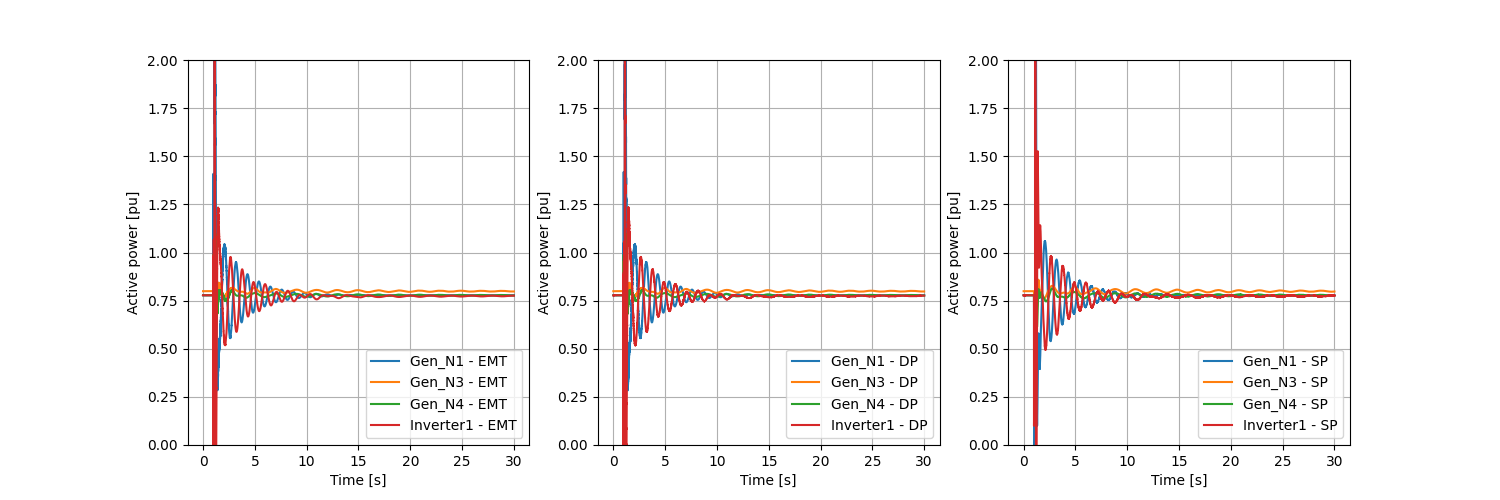

In [12]:
plot_varible(ts_dpsim_emt_1inverter, ts_dpsim_dp_1inverter, ts_dpsim_sp_1inverter, gen_list_1inverter, inverter_list_1inverter, "Pe", y_lim=[0., 2], x_lim=[], divider=900000000)

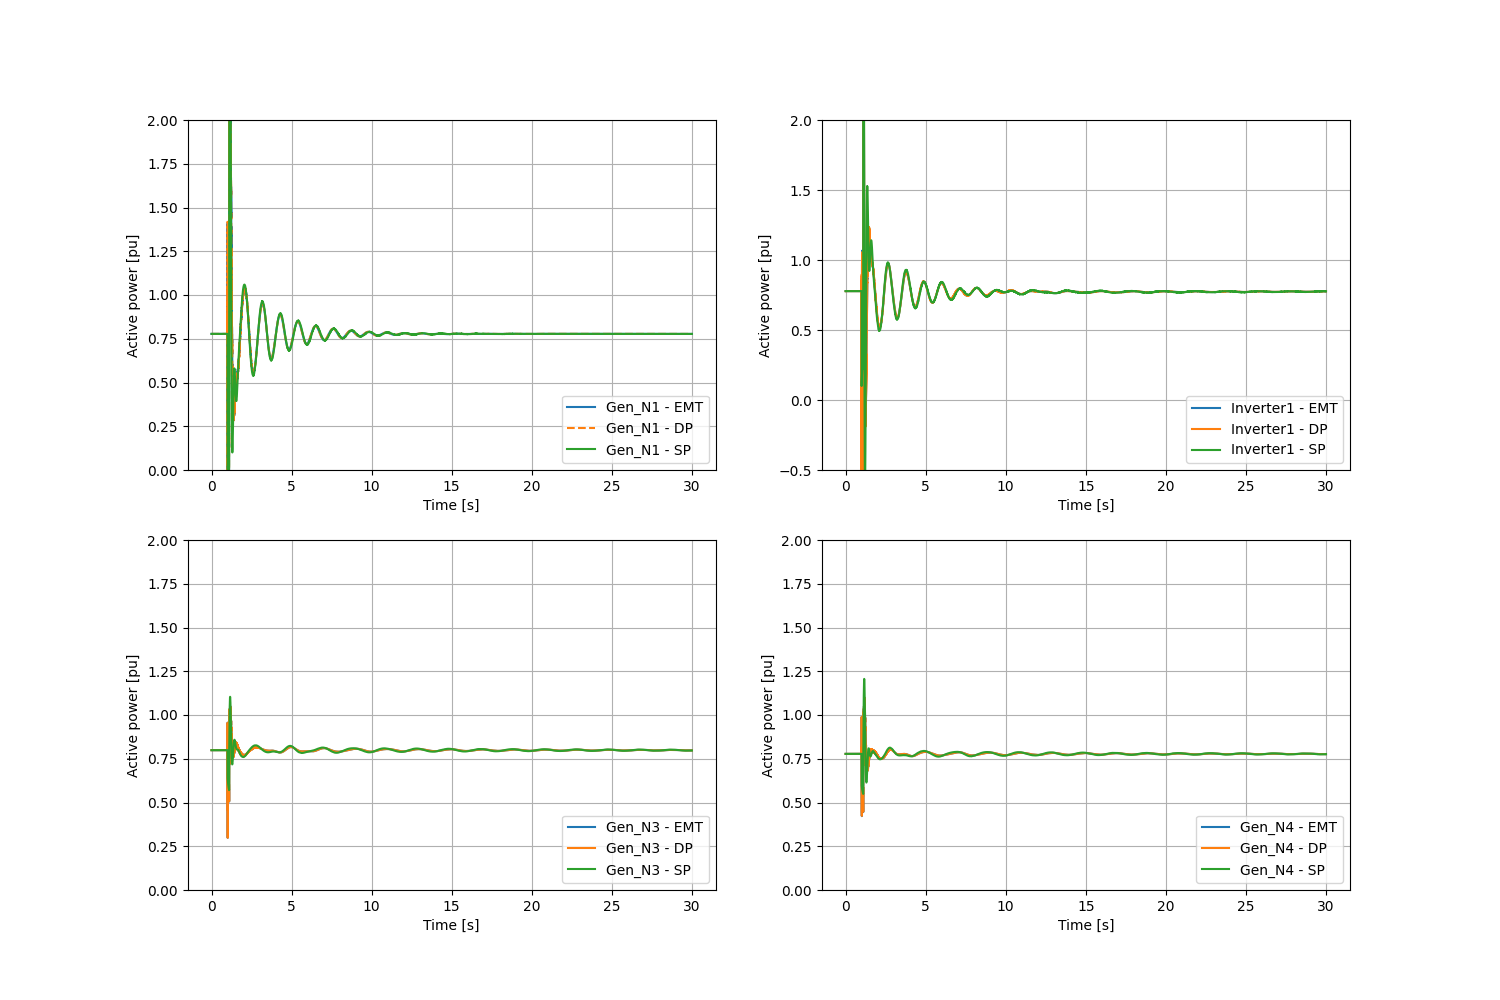

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

   
# Plot electrical power SG
gen_name = "Gen_N1"
axes[0][0].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
axes[0][0].plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values, '--', label='{} - DP'.format(gen_name))
axes[0][0].plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values, label='{} - SP'.format(gen_name))
axes[0][0].legend(loc='lower right')
axes[0][0].set_xlabel('Time [s]')
axes[0][0].set_ylabel('Active power [pu]')
axes[0][0].set_ylim([0., 2.0])
axes[0][0].grid()

# Plot electricalInverter 1
gen_name = "Inverter1"
axes[0][1].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values/900000000, label='{} - EMT'.format(gen_name))
axes[0][1].plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values/900000000, label='{} - DP'.format(gen_name))
axes[0][1].plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values/900000000, label='{} - SP'.format(gen_name))
axes[0][1].legend(loc='lower right')
axes[0][1].set_xlabel('Time [s]')
axes[0][1].set_ylabel('Active power [pu]')
axes[0][1].set_ylim([-0.5, 2.0])
#axes[0][1].set_xlim([0.98, 1.05])
axes[0][1].grid()

# Plot electrical power SG
gen_name = "Gen_N3"
axes[1][0].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
axes[1][0].plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values, label='{} - DP'.format(gen_name))
axes[1][0].plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values, label='{} - SP'.format(gen_name))
axes[1][0].legend(loc='lower right')
axes[1][0].set_xlabel('Time [s]')
axes[1][0].set_ylabel('Active power [pu]')
axes[1][0].set_ylim([0., 2.0])
axes[1][0].grid()

# Plot electrical power SG
gen_name = "Gen_N4"
axes[1][1].plot(ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.Pe'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
axes[1][1].plot(ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.Pe'.format(gen_name)].values, label='{} - DP'.format(gen_name))
axes[1][1].plot(ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.Pe'.format(gen_name)].values, label='{} - SP'.format(gen_name))
axes[1][1].legend(loc='lower right')
axes[1][1].set_xlabel('Time [s]')
axes[1][1].set_ylabel('Active power [pu]')
axes[1][1].set_ylim([0., 2.0])
axes[1][1].grid()

### Omega

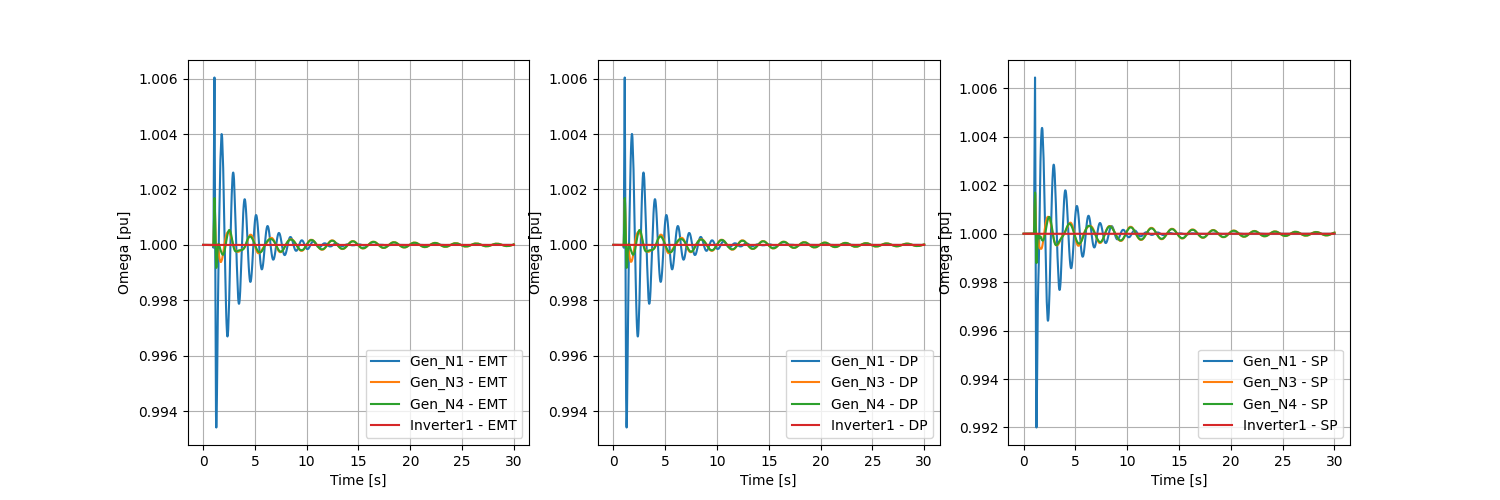

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot electrical power SG
for gen_name in gen_list_1inverter:
    axes[0].plot(ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
    axes[1].plot(ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].values, label='{} - DP'.format(gen_name))
    axes[2].plot(ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].values, label='{} - SP'.format(gen_name))
        
# Log electrical power Inverters
for idx, inverter in enumerate(inverter_list_1inverter):
    axes[0].plot(ts_dpsim_emt_1inverter['Inverter{}.w'.format(idx+1)].time, ts_dpsim_emt_1inverter['Inverter{}.w'.format(idx+1)].values/(2*np.pi*60), label='Inverter{} - EMT'.format(idx+1))
    axes[1].plot(ts_dpsim_dp_1inverter['Inverter{}.w'.format(idx+1)].time, ts_dpsim_dp_1inverter['Inverter{}.w'.format(idx+1)].values/(2*np.pi*60), label='Inverter{} - DP'.format(idx+1))
    axes[2].plot(ts_dpsim_sp_1inverter['Inverter{}.w'.format(idx+1)].time, ts_dpsim_sp_1inverter['Inverter{}.w'.format(idx+1)].values/(2*np.pi*60), label='Inverter{} - SP'.format(idx+1))

for ax in axes:
    ax.legend(loc='lower right')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Omega [pu]')
    #ax.set_ylim([0., 2])
    ax.grid()

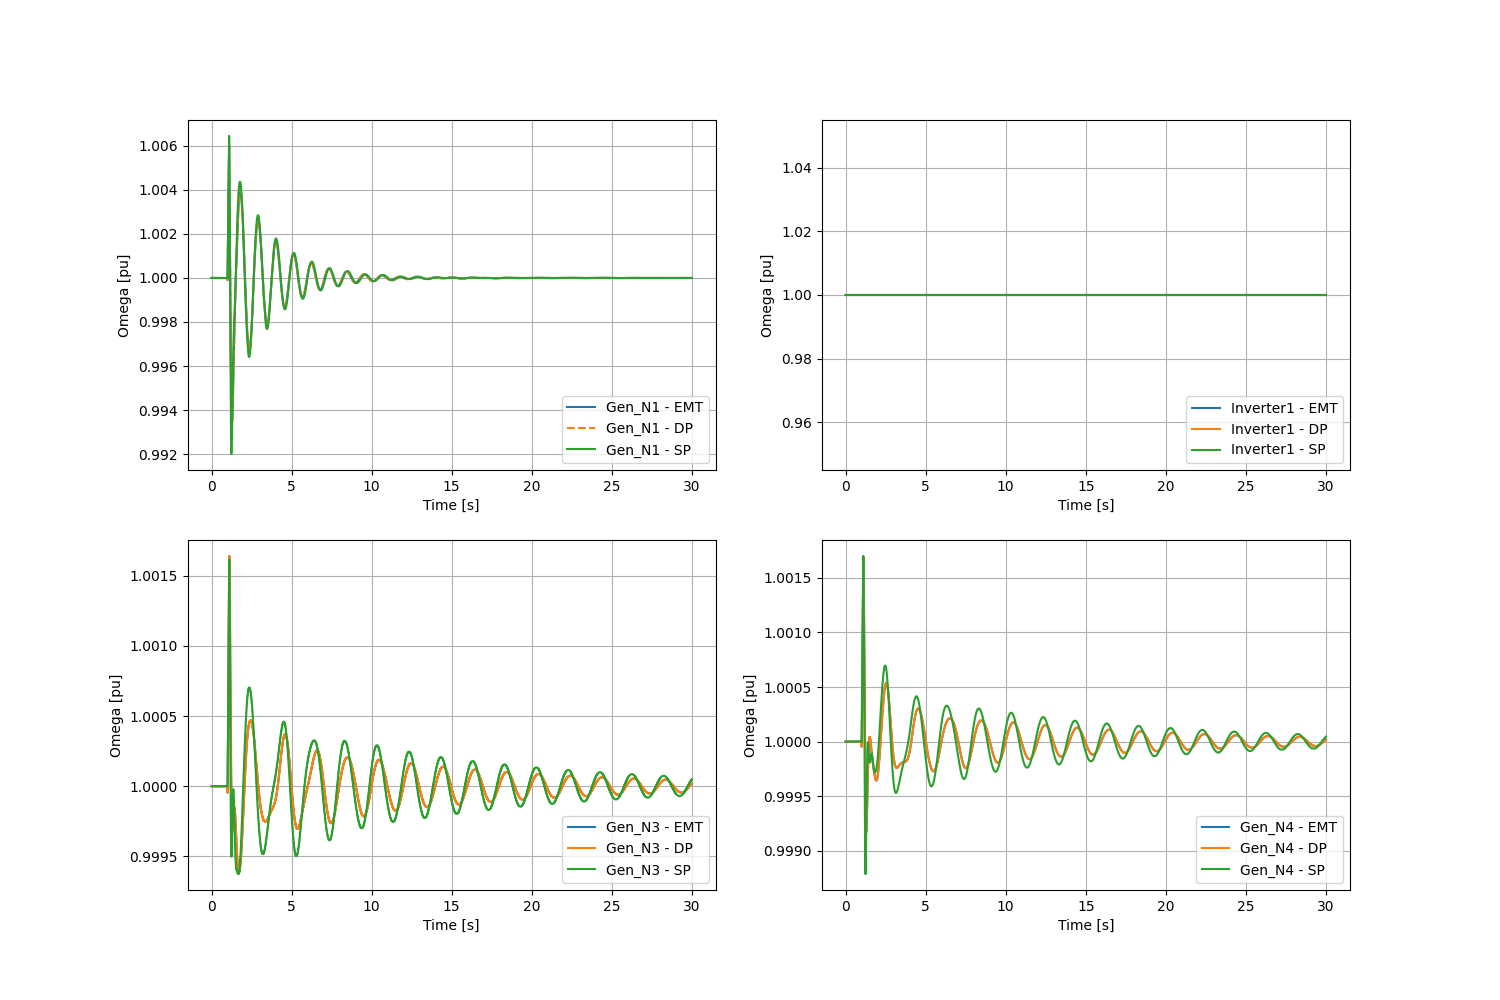

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

   
# Plot electrical power SG
gen_name = "Gen_N1"
axes[0][0].plot(ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
axes[0][0].plot(ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].values, '--', label='{} - DP'.format(gen_name))
axes[0][0].plot(ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].values, label='{} - SP'.format(gen_name))
axes[0][0].legend(loc='lower right')
axes[0][0].set_xlabel('Time [s]')
axes[0][0].set_ylabel('Omega [pu]')
#axes[0][0].set_ylim([0., 2.0])
axes[0][0].grid()

# Plot electricalInverter 1
gen_name = "Inverter1"
axes[0][1].plot(ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].values/(2*np.pi*60), label='{} - EMT'.format(gen_name))
axes[0][1].plot(ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].values/(2*np.pi*60), label='{} - DP'.format(gen_name))
axes[0][1].plot(ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].values/(2*np.pi*60), label='{} - SP'.format(gen_name))
axes[0][1].legend(loc='lower right')
axes[0][1].set_xlabel('Time [s]')
axes[0][1].set_ylabel('Omega [pu]')
#axes[0][1].set_ylim([-0.5, 2.0])
axes[0][1].grid()

# Plot electrical power SG
gen_name = "Gen_N3"
axes[1][0].plot(ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
axes[1][0].plot(ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].values, label='{} - DP'.format(gen_name))
axes[1][0].plot(ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].values, label='{} - SP'.format(gen_name))
axes[1][0].legend(loc='lower right')
axes[1][0].set_xlabel('Time [s]')
axes[1][0].set_ylabel('Omega [pu]')
#axes[1][0].set_ylim([0., 2.0])
axes[1][0].grid()

# Plot electrical power SG
gen_name = "Gen_N4"
axes[1][1].plot(ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
axes[1][1].plot(ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_dp_1inverter['{}.w'.format(gen_name)].values, label='{} - DP'.format(gen_name))
axes[1][1].plot(ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_sp_1inverter['{}.w'.format(gen_name)].values, label='{} - SP'.format(gen_name))
axes[1][1].legend(loc='lower right')
axes[1][1].set_xlabel('Time [s]')
axes[1][1].set_ylabel('Omega [pu]')
#axes[1][1].set_ylim([0., 2.0])
axes[1][1].grid()

### Plot Inverter Vsource

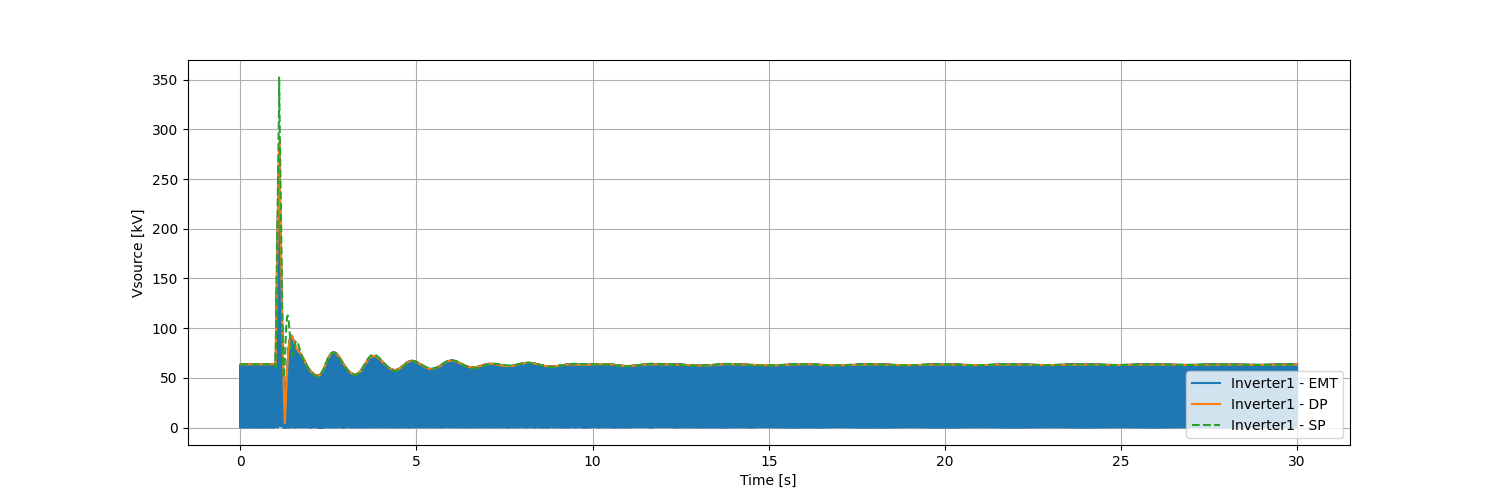

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
       
for idx, inverter in enumerate(inverter_list_1inverter):
    axes.plot(ts_dpsim_emt_1inverter['Inverter{}.Vsref_0'.format(idx+1)].time, np.abs(ts_dpsim_emt_1inverter['Inverter{}.Vsref_0'.format(idx+1)].values)/1000, label='Inverter{} - EMT'.format(idx+1))
    axes.plot(ts_dpsim_dp_1inverter['Inverter{}.Vsref'.format(idx+1)].time, np.sqrt(2/3)*ts_dpsim_dp_1inverter['Inverter{}.Vsref'.format(idx+1)].abs().values/1000, label='Inverter{} - DP'.format(idx+1))
    axes.plot(ts_dpsim_sp_1inverter['Inverter{}.Vsref'.format(idx+1)].time, np.sqrt(2/3)*ts_dpsim_sp_1inverter['Inverter{}.Vsref'.format(idx+1)].abs().values/1000, '--', label='Inverter{} - SP'.format(idx+1))
    #axes[1].plot(ts_dpsim_dp_1inverter['Inverter{}.Vsref'.format(idx+1)].time, ts_dpsim_dp_1inverter['Inverter{}.Vsref'.format(idx+1)].values/1000, label='Inverter{} - DP'.format(idx+1))
    #axes[2].plot(ts_dpsim_sp_1inverter['Inverter{}.Vsref'.format(idx+1)].time, ts_dpsim_sp_1inverter['Inverter{}.Vsref'.format(idx+1)].values/1000, label='Inverter{} - SP'.format(idx+1))

#for ax in axes:
axes.legend(loc='lower right')
axes.set_xlabel('Time [s]')
axes.set_ylabel('Vsource [kV]')
#axes.set_ylim([0., 2])
axes.grid()

### PLot Inverter Current

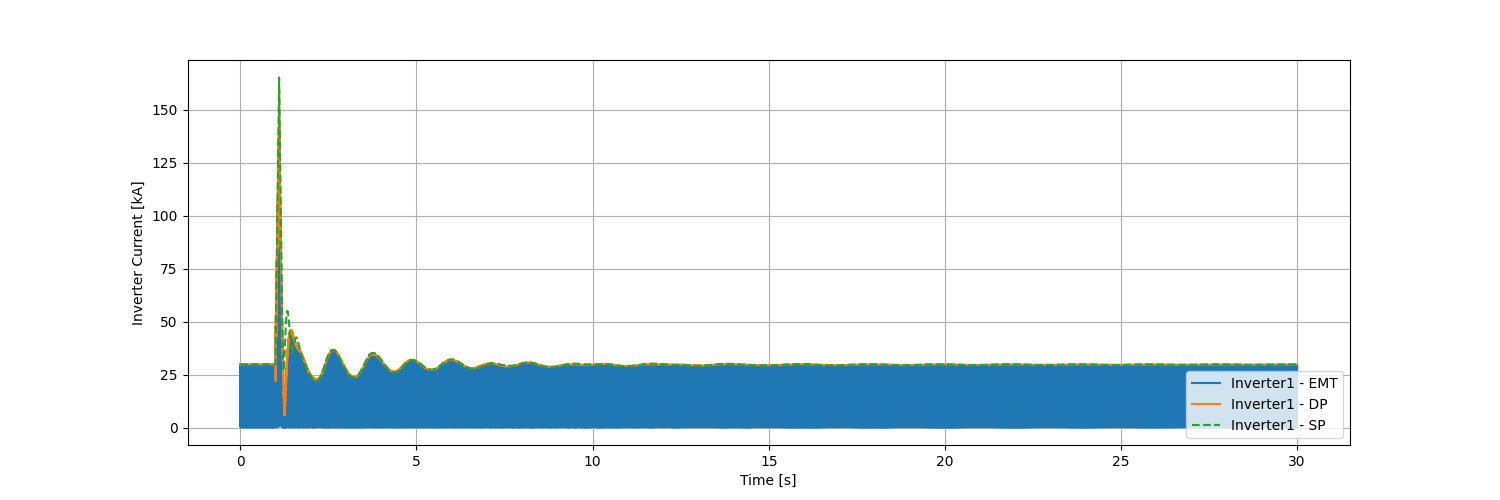

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
       
for idx, inverter in enumerate(inverter_list_1inverter):
    axes.plot(ts_dpsim_emt_1inverter['Inverter{}.I_0'.format(idx+1)].time, np.abs(ts_dpsim_emt_1inverter['Inverter{}.I_0'.format(idx+1)].values)/1000, label='Inverter{} - EMT'.format(idx+1))
    axes.plot(ts_dpsim_dp_1inverter['Inverter{}.I'.format(idx+1)].time, np.sqrt(2/3)*ts_dpsim_dp_1inverter['Inverter{}.I'.format(idx+1)].abs().values/1000, label='Inverter{} - DP'.format(idx+1))
    axes.plot(ts_dpsim_sp_1inverter['Inverter{}.I'.format(idx+1)].time, np.sqrt(2/3)*ts_dpsim_sp_1inverter['Inverter{}.I'.format(idx+1)].abs().values/1000, '--', label='Inverter{} - SP'.format(idx+1))
    #axes[1].plot(ts_dpsim_dp_1inverter['Inverter{}.Vsref'.format(idx+1)].time, ts_dpsim_dp_1inverter['Inverter{}.Vsref'.format(idx+1)].values/1000, label='Inverter{} - DP'.format(idx+1))
    #axes[2].plot(ts_dpsim_sp_1inverter['Inverter{}.Vsref'.format(idx+1)].time, ts_dpsim_sp_1inverter['Inverter{}.Vsref'.format(idx+1)].values/1000, label='Inverter{} - SP'.format(idx+1))

#for ax in axes:
axes.legend(loc='lower right')
axes.set_xlabel('Time [s]')
axes.set_ylabel('Inverter Current [kA]')
#axes.set_ylim([0., 2])
axes.grid()

#### Electrical torque 2 Inverters

### Omega

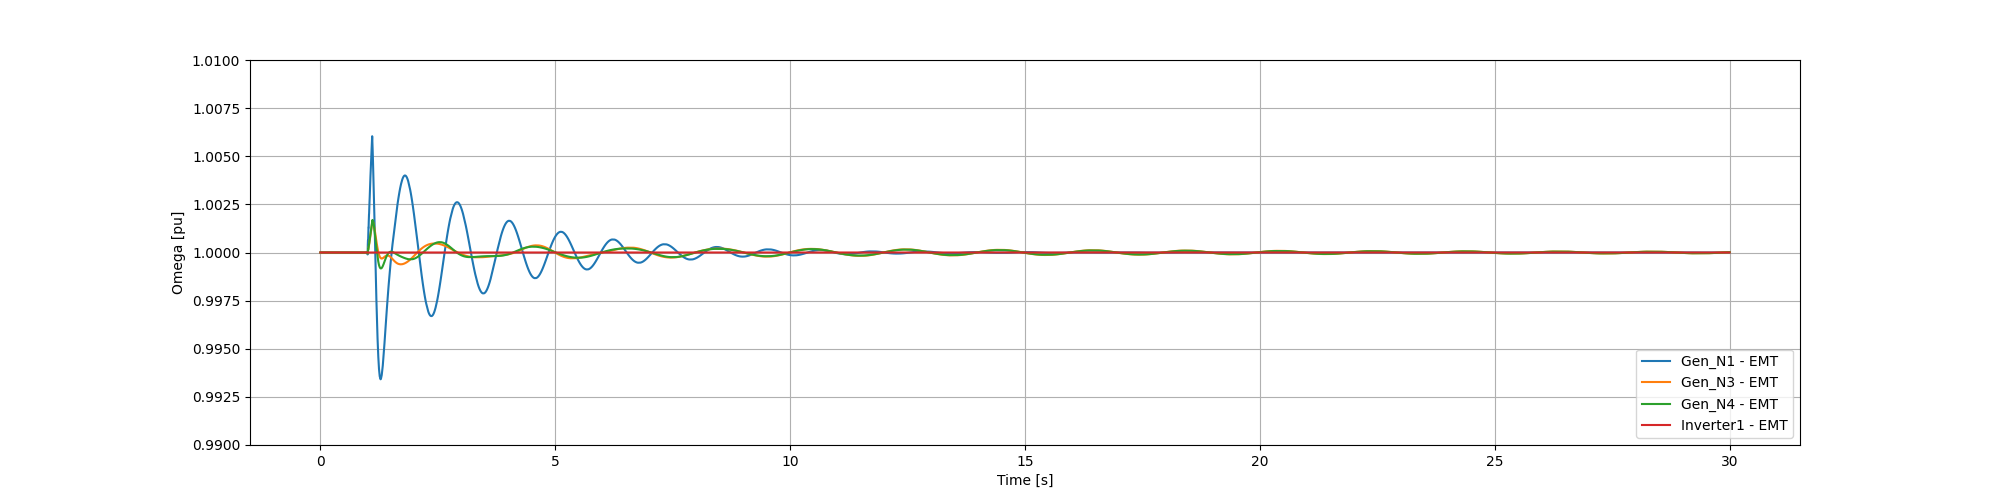

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
for gen_name in gen_list_1inverter:
    axes.plot(ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].time, ts_dpsim_emt_1inverter['{}.w'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
    
axes.plot(ts_dpsim_emt_1inverter['{}.w'.format("Inverter1")].time, ts_dpsim_emt_1inverter['{}.w'.format("Inverter1")].values/(2*np.pi*60), label='{} - EMT'.format("Inverter1"))

"""
# Plot electrical power SG
for gen_name in gen_list:
    axes[0].plot(ts_dpsim_emt['{}.w'.format(gen_name)].time, ts_dpsim_emt['{}.w'.format(gen_name)].values, label='{} - EMT'.format(gen_name))
    axes[1].plot(ts_dpsim_dp['{}.w'.format(gen_name)].time, ts_dpsim_dp['{}.w'.format(gen_name)].values, label='{} - DP'.format(gen_name))
    axes[2].plot(ts_dpsim_sp['{}.w'.format(gen_name)].time, ts_dpsim_sp['{}.w'.format(gen_name)].values, label='{} - SP'.format(gen_name))
        
# Log electrical power Inverters
for idx, inverter in enumerate(inverter_list):
    axes[0].plot(ts_dpsim_emt['Inverter{}.w'.format(idx+1)].time, ts_dpsim_emt['Inverter{}.w'.format(idx+1)].values, label='Inverter{} - EMT'.format(idx+1))
    axes[1].plot(ts_dpsim_dp['Inverter{}.w'.format(idx+1)].time, ts_dpsim_dp['Inverter{}.w'.format(idx+1)].values, label='Inverter{} - DP'.format(idx+1))
    axes[2].plot(ts_dpsim_sp['Inverter{}.w'.format(idx+1)].time, ts_dpsim_sp['Inverter{}.w'.format(idx+1)].values, label='Inverter{} - SP'.format(idx+1))
"""

axes.legend(loc='lower right')
axes.set_xlabel('Time [s]')
axes.set_ylabel('Omega [pu]')
axes.set_ylim([0.99, 1.01])
axes.grid()

#### Power exchange between Area 1 & Area 2

'\n#second axis of first plot\nroi_start_second=0.99\nroi_end_second=1.13\nylim = axes[0].get_ylim()\nroi = range(int(roi_start_second/timestep_common), int(roi_end_second/timestep_common))\nax2 = axes[0].inset_axes([0.2, 0.15, .7, .55])\n#x1, x2, y1, y2 = roi_start_second, roi_end_second, ylim[0], ylim[1]\nx1, x2, y1, y2 = roi_start_second, roi_end_second, -300, 750\nmark_inset(axes[0], ax2, loc1=2, loc2=3, fc="none", ec=\'1\', color=\'black\')\nax2.plot(time[roi], (power_line3_emt + power_line4_emt - power_switch_emt)[roi] * 1e-6, label=\'EMT\', linewidth=1)   \nax2.plot(time[roi], (power_line3_dp + power_line4_dp - power_switch_dp).real[roi] * 1e-6, \'--\', label=\'DP\', linewidth=1)   \n#ax2.plot(time[roi], (power_line3_sp + power_line4_sp - power_switch_sp).real[roi] * 1e-6, \'--\', label=\'SP\', linewidth=1)    \nax2.set_xticklabels([])\nax2.set_yticklabels([])\nax2.set_xlim(x1, x2)\nax2.set_ylim(y1, y2)\nax2.tick_params(top=False, bottom=False, left=False, right=False, labelleft

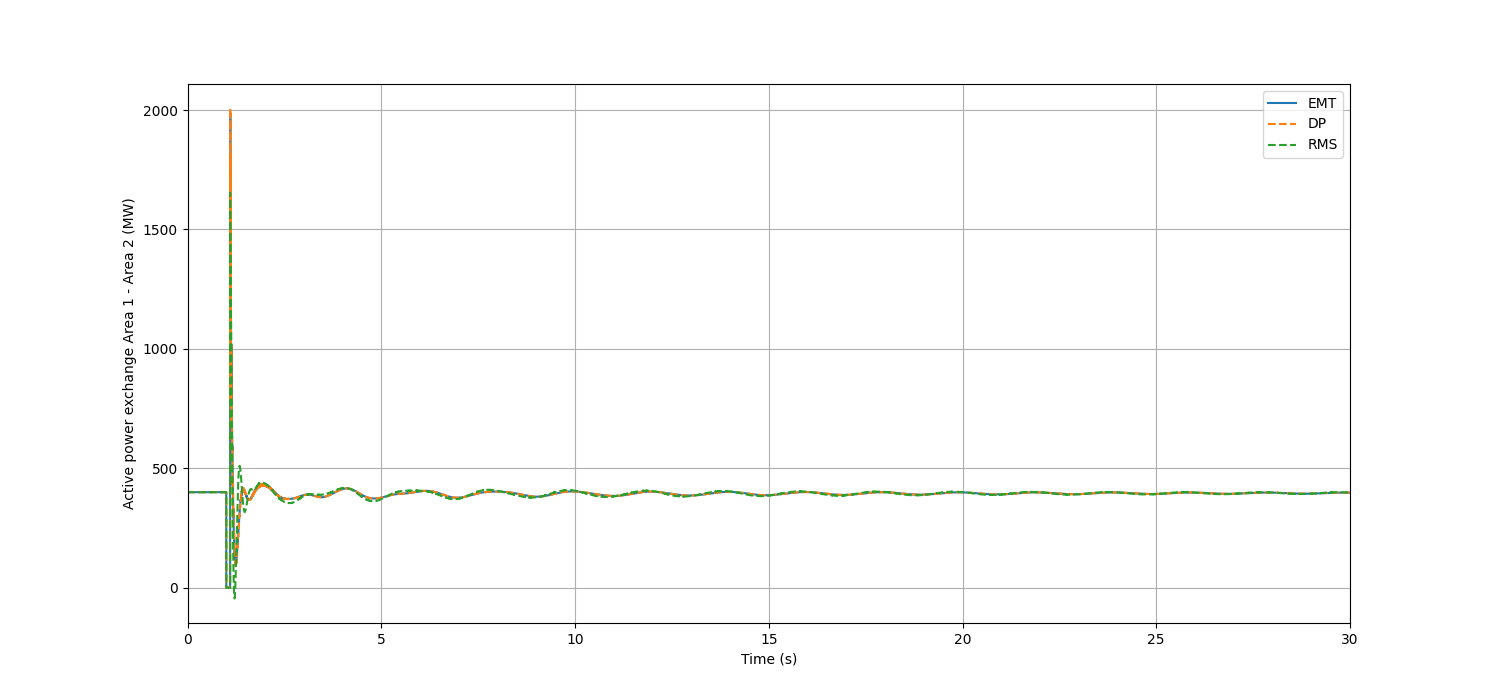

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 

timestep_common = 1e-4
t_begin = 0.0
t_end = 30
begin_idx = int(t_begin/timestep_common)
end_idx= int(t_end/timestep_common)
time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

### Calulate power exchange classical case
power_line3_sp = np.conjugate(ts_dpsim_sp_1inverter["line3_7-8.I"].interpolate(timestep_common).values[begin_idx:end_idx]) * ts_dpsim_sp_1inverter["N7.V"].interpolate(timestep_common).values[begin_idx:end_idx]
power_line4_sp = np.conjugate(ts_dpsim_sp_1inverter["line4_7-8.I"].interpolate(timestep_common).values[begin_idx:end_idx]) * ts_dpsim_sp_1inverter["N7.V"].interpolate(timestep_common).values[begin_idx:end_idx]
power_switch_sp = np.conjugate(ts_dpsim_sp_1inverter["Switch.I"].interpolate(timestep_common).values[begin_idx:end_idx]) * ts_dpsim_sp_1inverter["N8.V"].interpolate(timestep_common).values[begin_idx:end_idx]
power_switch_sp = 0

power_line3_dp = np.conjugate(ts_dpsim_dp_1inverter["line3_7-8.I"].interpolate(timestep_common).values[begin_idx:end_idx]) * ts_dpsim_dp_1inverter["N7.V"].interpolate(timestep_common).values[begin_idx:end_idx]
power_line4_dp = np.conjugate(ts_dpsim_dp_1inverter["line4_7-8.I"].interpolate(timestep_common).values[begin_idx:end_idx]) * ts_dpsim_dp_1inverter["N7.V"].interpolate(timestep_common).values[begin_idx:end_idx]
power_switch_dp = np.conjugate(ts_dpsim_dp_1inverter["Switch.I"].interpolate(timestep_common).values[begin_idx:end_idx]) * ts_dpsim_dp_1inverter["N8.V"].interpolate(timestep_common).values[begin_idx:end_idx]
power_switch_dp = 0

power_line3_emt = ts_dpsim_emt_1inverter["line3_7-8.I_0"].interpolate(timestep_common).values[begin_idx:end_idx] * ts_dpsim_emt_1inverter["N7.V_0"].interpolate(timestep_common).values[begin_idx:end_idx] + \
                  ts_dpsim_emt_1inverter["line3_7-8.I_1"].interpolate(timestep_common).values[begin_idx:end_idx] * ts_dpsim_emt_1inverter["N7.V_1"].interpolate(timestep_common).values[begin_idx:end_idx] + \
                  ts_dpsim_emt_1inverter["line3_7-8.I_2"].interpolate(timestep_common).values[begin_idx:end_idx] * ts_dpsim_emt_1inverter["N7.V_2"].interpolate(timestep_common).values[begin_idx:end_idx]
power_line4_emt = ts_dpsim_emt_1inverter["line4_7-8.I_0"].interpolate(timestep_common).values[begin_idx:end_idx] * ts_dpsim_emt_1inverter["N7.V_0"].interpolate(timestep_common).values[begin_idx:end_idx] + \
                  ts_dpsim_emt_1inverter["line4_7-8.I_1"].interpolate(timestep_common).values[begin_idx:end_idx] * ts_dpsim_emt_1inverter["N7.V_1"].interpolate(timestep_common).values[begin_idx:end_idx] + \
                  ts_dpsim_emt_1inverter["line4_7-8.I_2"].interpolate(timestep_common).values[begin_idx:end_idx] * ts_dpsim_emt_1inverter["N7.V_2"].interpolate(timestep_common).values[begin_idx:end_idx]       
power_switch_emt = ts_dpsim_emt_1inverter["Switch.I_0"].interpolate(timestep_common).values[begin_idx:end_idx] * ts_dpsim_emt_1inverter["N8.V_0"].interpolate(timestep_common).values[begin_idx:end_idx] + \
                   ts_dpsim_emt_1inverter["Switch.I_1"].interpolate(timestep_common).values[begin_idx:end_idx] * ts_dpsim_emt_1inverter["N8.V_1"].interpolate(timestep_common).values[begin_idx:end_idx] + \
                   ts_dpsim_emt_1inverter["Switch.I_2"].interpolate(timestep_common).values[begin_idx:end_idx] * ts_dpsim_emt_1inverter["N8.V_2"].interpolate(timestep_common).values[begin_idx:end_idx]
power_switch_emt = 0

#fig, ax1 = plt.subplots(figsize=(7, 4))
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(time, (power_line3_emt + power_line4_emt - power_switch_emt) * 1e-6, label='EMT')
axes.plot(time, (power_line3_dp + power_line4_dp - power_switch_dp).real * 1e-6, '--', label='DP')
axes.plot(time, (power_line3_sp + power_line4_sp - power_switch_sp).real  * 1e-6, '--', label='RMS')
axes.legend(loc='upper right')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Active power exchange Area 1 - Area 2 (MW)')
axes.grid()
axes.set_xlim([0., 30])
#axes[0].set_ylim([100, 500])
#plt.ylim([-100, 700])
#axes[0].axvline(x=8.28849219, color = 'r', linestyle = '-')
#axes[0].axvline(x=10.3410821, color = 'r', linestyle = '-')

"""
#second axis of first plot
roi_start_second=0.99
roi_end_second=1.13
ylim = axes[0].get_ylim()
roi = range(int(roi_start_second/timestep_common), int(roi_end_second/timestep_common))
ax2 = axes[0].inset_axes([0.2, 0.15, .7, .55])
#x1, x2, y1, y2 = roi_start_second, roi_end_second, ylim[0], ylim[1]
x1, x2, y1, y2 = roi_start_second, roi_end_second, -300, 750
mark_inset(axes[0], ax2, loc1=2, loc2=3, fc="none", ec='1', color='black')
ax2.plot(time[roi], (power_line3_emt + power_line4_emt - power_switch_emt)[roi] * 1e-6, label='EMT', linewidth=1)   
ax2.plot(time[roi], (power_line3_dp + power_line4_dp - power_switch_dp).real[roi] * 1e-6, '--', label='DP', linewidth=1)   
#ax2.plot(time[roi], (power_line3_sp + power_line4_sp - power_switch_sp).real[roi] * 1e-6, '--', label='SP', linewidth=1)    
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xlim(x1, x2)
ax2.set_ylim(y1, y2)
ax2.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=True)
ax2.grid()
plt.tight_layout()
#plt.savefig("./plotting/PowerExchange_ClassicInertia.pdf")
"""